In [85]:
import numpy as np
import lightkurve as lk
import astropy.units as u
import pymc3 as pm
import theano.tensor as tt
import exoplanet as xo

In [86]:
TARGET = "TIC 410214986"
search = lk.search_lightcurvefile(TARGET, cadence='long')
print(search)

SearchResult containing 1 data products.

 #   observation  target_name                     productFilename                     distance
--- ------------- ----------- ------------------------------------------------------- --------
  0 TESS Sector 1   410214986 tess2018206045859-s0001-0000000410214986-0120-s_lc.fits      0.0


In [87]:
file = search[0].download_all()
lc = file.stitch().remove_outliers().remove_nans()

/Users/cooperdoyle/opt/anaconda3/lib/python3.7/site-packages/lightkurve/collections.py:213: LightkurveWarning: Stitching a `LightCurveFileCollection` which contains both SAP and PDCSAP_FLUX. Using PDCSAP_FLUX. You can remove this warning by explicitely using `LightCurveFileCollection.PDCSAP_FLUX.stitch()`.
  LightkurveWarning)


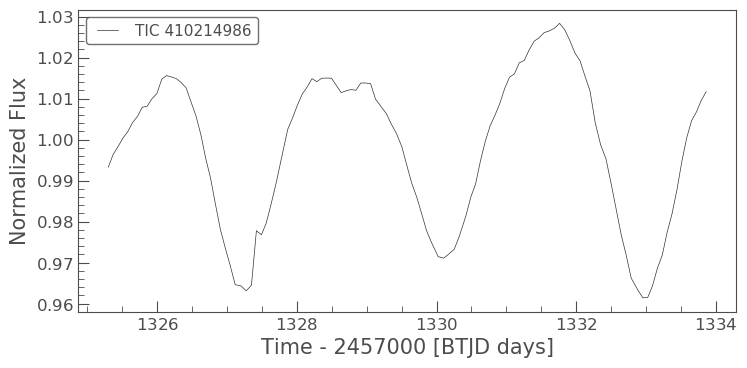

In [88]:
lc = lc[0:6000]
lc = lc[0::10]
lc.plot()

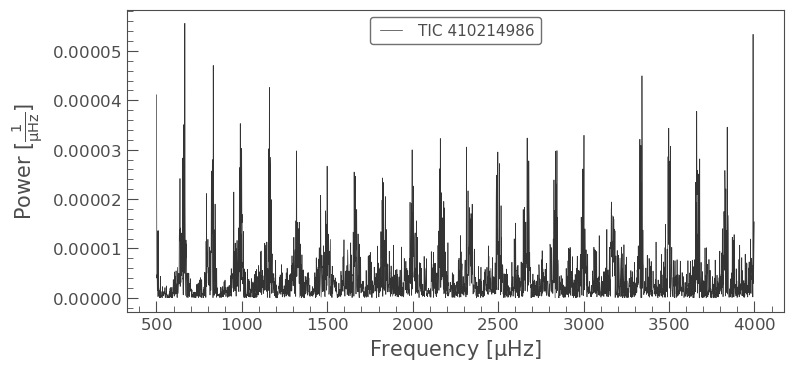

In [89]:
pg = lc.to_periodogram(method='lombscargle', normalization='psd',
                      minimum_frequency=500, maximum_frequency=4000)
pg.plot();

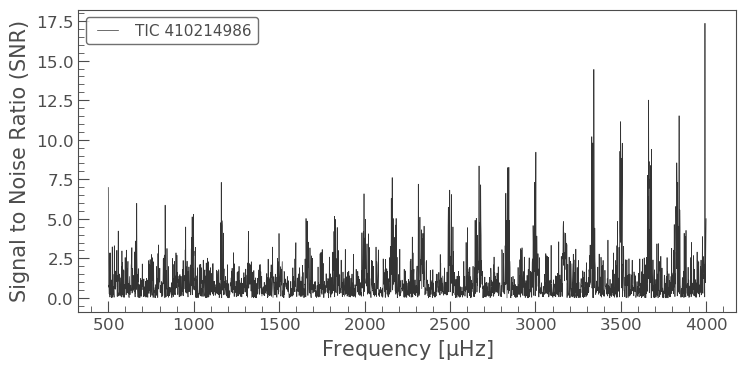

In [90]:
snr = pg.flatten()
seis = snr.to_seismology()
seis.periodogram.plot();

numax_guess =  3595.0 uHz


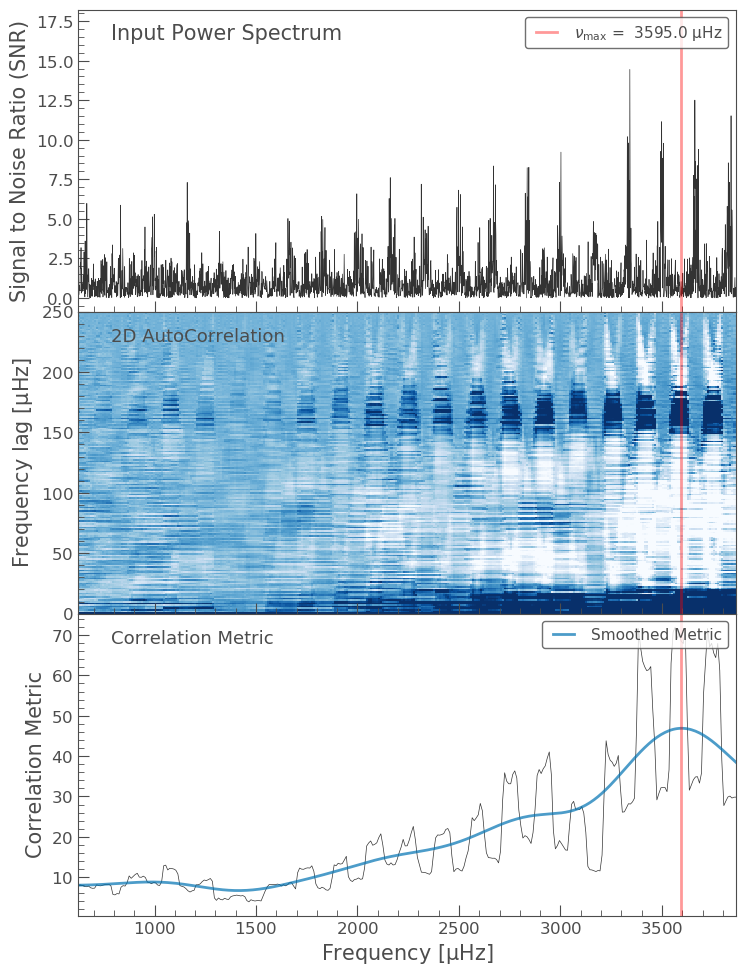

In [91]:
numax_guess = seis.estimate_numax()
print("numax_guess = ", numax_guess)
seis.diagnose_numax();

In [92]:
# Make sure that all the data have the right type
x = np.ascontiguousarray(lc.time, dtype=np.float64)
y = np.ascontiguousarray(lc.flux, dtype=np.float64)
yerr = np.ascontiguousarray(lc.flux_err, dtype=np.float64)

# Convert to ppm
y = (y - 1) * 1e6
yerr *= 1e6

# This will be useful for converting between uHz and 1/d for frequencies
uHz_conv = u.uHz.to(1/u.day)

# Build the model in PyMC3
with pm.Model() as gp_model:
    
    # The mean stellar flux (relative to the normalized baseline) in ppm
    mean = pm.Normal("mean", mu=0, sd=np.std(y))
    
    # A jitter term to capture underestimated error bars and model misspecification
    logs2 = pm.Normal("logs2", mu=np.log(np.mean(yerr**2)), sd=10.0)
    
    # The first two terms capture the granulation and they each have 2 parameters:
    #
    # 1. The amplitude of the variability (in ppm^2), and
    # 2. The turnover (angular) frequency in 1/d
    logw_init = np.log(2*np.pi) - np.log([5, 10])
    loga = pm.Normal("loga", mu=np.log(np.var(y)), sd=10.0, shape=2)
    logw0 = pm.Normal("logw0", mu=logw_init, sd=10.0, shape=2)
    logS0 = pm.Deterministic("logS0", loga-logw0+0.5*np.log(2))
    
    kernel = xo.gp.terms.SHOTerm(log_S0=logS0[0], log_w0=logw0[0], Q=1/np.sqrt(2))
    kernel += xo.gp.terms.SHOTerm(log_S0=logS0[1], log_w0=logw0[1], Q=1/np.sqrt(2))

    # The third term captures the power excess and it has 3 parameters:
    #
    # 1. The amplitude of the variability (in ppm^2),
    # 2. The quality factor of the power envelope (constrained to be >0.5), and
    # 3. The central frequency of the power excess (in uHz); we will interpret
    #    this as nu_max
    logQ_peak_init = 1.0
    logw_peak_init = np.log(2*np.pi*uHz_conv*numax_guess.value)
    loga_peak = pm.Normal("loga_peak", mu=np.log(np.var(y)), sd=10.0)
    lognumax = pm.Normal("lognumax", mu=np.log(numax_guess.value), sd=500)
    numax = pm.Deterministic("numax", tt.exp(lognumax))
    w0_peak = pm.Deterministic("w0_peak", 2*np.pi*uHz_conv*numax)
    logQ_peak = pm.Normal("logQ", mu=logQ_peak_init, sd=2.0)
    Q_peak = pm.Deterministic("Q_peak", 0.5+tt.exp(logQ_peak))
    logS_peak = loga_peak - tt.log(w0_peak * Q_peak)

    kernel += xo.gp.terms.SHOTerm(log_S0=logS_peak, w0=w0_peak, Q=Q_peak)
    
    # We put this together and evaluate the GP likelihood
    gp = xo.gp.GP(kernel, x, yerr**2 + tt.exp(logs2))
    pm.Potential("loglike", gp.log_likelihood(y - mean))
    
    # Then we maximize the log posterior to find an estimate of the maximum
    # a posteriori (map) parameters. Note: The order of these optimizations
    # has been chosen to work for this problem using a combination of intution
    # and trial and error.
    gp_map_soln = gp_model.test_point
    gp_map_soln = xo.optimize(gp_map_soln, vars=[mean])
    gp_map_soln = xo.optimize(gp_map_soln, vars=[logs2])
    gp_map_soln = xo.optimize(gp_map_soln, vars=[loga_peak])
    gp_map_soln = xo.optimize(gp_map_soln, vars=[loga, logw0])
    gp_map_soln = xo.optimize(gp_map_soln, vars=[loga_peak])
    gp_map_soln = xo.optimize(gp_map_soln, vars=[lognumax])
    gp_map_soln = xo.optimize(gp_map_soln, vars=[mean, logs2, loga, logw0])
    gp_map_soln = xo.optimize(gp_map_soln)

optimizing logp for variables: [mean]
2it [00:00, 57.28it/s, logp=-1.357797e+03] 
message: Optimization terminated successfully.
logp: -1357.796635495025 -> -1357.796635495025
optimizing logp for variables: [logs2]
8it [00:00, 178.09it/s, logp=-1.357787e+03]
message: Optimization terminated successfully.
logp: -1357.796635495025 -> -1357.7871295376253
optimizing logp for variables: [loga_peak]
8it [00:00, 152.00it/s, logp=-1.136474e+03]
message: Optimization terminated successfully.
logp: -1357.7871295376253 -> -1136.4735231084956
optimizing logp for variables: [logw0, loga]
41it [00:00, 287.44it/s, logp=-1.122568e+03]
message: Optimization terminated successfully.
logp: -1136.4735231084956 -> -1122.5676168886434
optimizing logp for variables: [loga_peak]
6it [00:00, 143.90it/s, logp=-1.121931e+03]
message: Optimization terminated successfully.
logp: -1122.5676168886434 -> -1121.9309343946582
optimizing logp for variables: [lognumax]
2it [00:00, 57.92it/s, logp=-1.121931e+03] 
message:

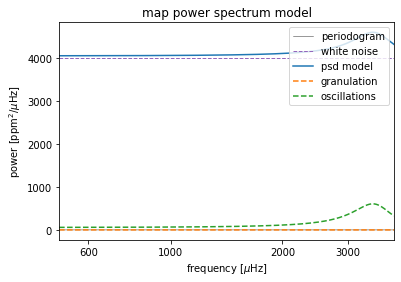

In [93]:
import matplotlib.pyplot as plt

var_ppm = np.mean(yerr**2) + np.exp(gp_map_soln["logs2"])
wn = 0.25*(x.max() - x.min()) * var_ppm / len(x)
logf = np.log10(pg.frequency.value)

plt.plot(logf, pg.power.value, "k", lw=0.5, alpha=0.8, label="periodogram")
plt.axhline(wn, lw=1, color="C4", ls="dashed", label="white noise")

labels = ["granulation", "oscillations"]
with gp_model:
    psd = gp.kernel.psd(2*np.pi*pg.frequency.to(1/u.day).value)
    plt.plot(logf, xo.eval_in_model(psd, gp_map_soln) + wn, label="psd model")
    for i, term in enumerate(gp.kernel.terms):
        psd = term.psd(2*np.pi*pg.frequency.to(1/u.day).value)
        plt.plot(logf, xo.eval_in_model(psd, gp_map_soln), "--", label=labels[i])

plt.xlim(logf.min(), logf.max())
plt.xticks(np.log10([600, 1000, 2000, 3000]))
plt.gca().set_xticklabels(["600", "1000", "2000", "3000"])
plt.legend(fontsize=10, loc=1)
plt.xlabel("frequency [$\mu$Hz]")
plt.ylabel("power [ppm$^2/\mu$Hz]")
plt.title("map power spectrum model", fontsize=12);

In [94]:
true_x = np.linspace(x[0], x[-1], len(x))

In [95]:
with gp_model:
    mu, var = xo.eval_in_model(
        gp.predict(true_x, return_var=True, predict_mean=True), gp_map_soln
    )

Text(0, 0.5, 'y')

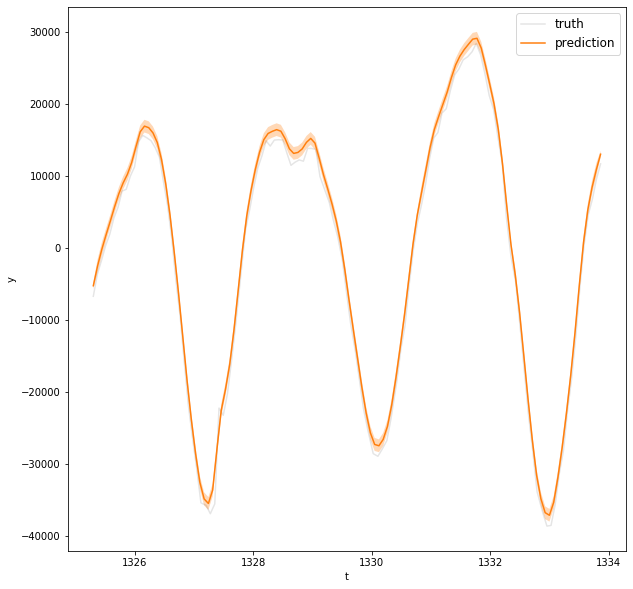

In [96]:
plt.figure(figsize=(10,10))

#plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0, alpha = 0.1, label="data")
plt.plot(x, y, "k", lw=1.5, alpha=0.1, label="truth")

# Plot the prediction and the 1-sigma uncertainty
sd = np.sqrt(var)
art = plt.fill_between(true_x, mu + sd, mu - sd, color="C1", alpha=0.3)
art.set_edgecolor("none")
plt.plot(true_x, mu, color="C1", label="prediction")

plt.legend(fontsize=12)
plt.xlabel("t")
plt.ylabel("y")

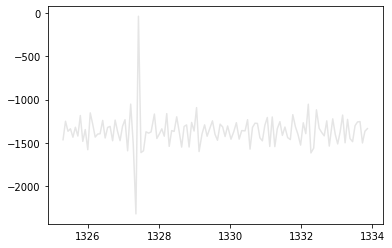

In [97]:
# Now compute the residuals
with gp_model:
    mu, var = xo.eval_in_model(
        gp.predict(x, return_var=True, predict_mean=True), gp_map_soln
    )

res = y - mu

plt.plot(x, res, "k", lw=1.5, alpha=0.1, label="truth")

In [98]:
# Fit the box least squares algorithm
import astropy.units as u
from astropy.timeseries import BoxLeastSquares

model = BoxLeastSquares(x * u.day, res, dy=yerr)
periodogram = model.autopower(0.2)

Peak ratio: 3.9676741348698714


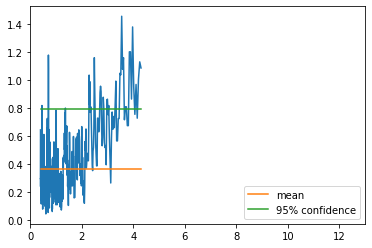

In [99]:
plt.plot(periodogram.period, periodogram.power)
avg_bls_power = np.mean(periodogram.power)
std_bls_power = np.std(periodogram.power)
plt.plot(periodogram.period, [avg_bls_power for i in range(len(periodogram.period))], label='mean')
plt.plot(periodogram.period, [avg_bls_power+2*std_bls_power for i in range(len(periodogram.period))], label='95% confidence')
plt.legend(loc='lower right')
plt.xlim(0,13)
print('Peak ratio:', np.max(periodogram.power)/avg_bls_power)